In [25]:
# %%
# --- セル 1: 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict, Iterable, Tuple, Optional
import mne  # MNE-Python
import re   # 正規表現
from collections import defaultdict

# %%
# --- セル 2: config 変数の定義 ---
# (src.config からのインポートが機能しない場合、ここで直接定義する)
try:
    import _init_notebook
    from src.config import (
        PROCESSED_DIR, SAMPLING_RATE, EEG_CHANNELS_TO_FILTER, N_JOBS
    )
except ImportError:
    print("src.config を読み込めないため、変数を仮設定します。")


# --- ★ 安静時データのパス設定 ---
DATA_DIR = Path(r"G:\マイドライブ\ALL_EEG_pcdh15")

# --- ★ 時間スライス設定 (10分 - 60分) ---
TIME_SLICE_START_SEC = 10 * 60  # 600秒
TIME_SLICE_END_SEC = 60 * 60    # 3600秒

# PSD計算用の周波数設定
PSD_FMIN = 1.0
PSD_FMAX = 40.0
WELCH_DURATION_SEC = 2.0 # Welch法のエポック長 (秒)

# configからチャンネル名を取得
try:
    CH_NAMES_CLEAN = [ch.replace('_filtered', '') for ch in EEG_CHANNELS_TO_FILTER]
except NameError:
    print("エラー: EEG_CHANNELS_TO_FILTER が config または仮設定にありません。")
    CH_NAMES_CLEAN = []

# %%
# --- セル 3: ファイル名解析ヘルパー関数 (新規) ---
def parse_filename_resting(file_path: Path) -> Optional[Tuple[str, str]]:
    """
    ファイル名から (mouse_id, genotype) を抽出する。
    'homo' を含むファイルは None を返す。
    """
    file_name = file_path.name.lower()
    
    # 'homo' を含むファイルは除外
    if 'homo' in file_name:
        return None
    
    # パターン1: (例: 176het... -> ID='176', G='Het')
    match_het = re.search(r'(\d+)(het)', file_name)
    if match_het:
        return match_het.group(1), 'Het'
    
    # パターン2: (例: WT404... -> ID='404', G='WT')
    match_wt = re.search(r'(wt)(\d+)', file_name)
    if match_wt:
        return match_wt.group(2), 'WT'
    
    # パターン3: (例: 176wt... -> ID='176', G='WT')
    match_wt_suffix = re.search(r'(\d+)(wt)', file_name)
    if match_wt_suffix:
        return match_wt_suffix.group(1), 'WT'
    
    return None

# %%
# --- セル 4: ファイル検索と重複排除 (新規) ---
def find_files_to_process(raw_dir: Path) -> List[Tuple[str, str, Path]]:
    """
    ディレクトリをスキャンし、'rest' を含み 'homo' を含まないファイルを探す。
    重複する Mouse ID が見つかった場合は警告を出し、除外する。
    重複のないファイルの (mouse_id, genotype, file_path) リストを返す。
    """
    print(f"スキャン中: {raw_dir}")
    # 'rest' を含む .npy ファイルを検索
    all_rest_files = list(raw_dir.glob('*rest*.npy'))
    if not all_rest_files:
        print("警告: '*rest*.npy' ファイルが見つかりません。")
        return []

    mouse_files_map = defaultdict(list)
    
    # ファイル名解析と 'homo' 除外
    for file_path in all_rest_files:
        parsed_info = parse_filename_resting(file_path)
        if parsed_info:
            mouse_id, genotype = parsed_info
            mouse_files_map[mouse_id].append((genotype, file_path))

    # 重複チェック
    files_to_process = []
    print("--- ファイル重複チェック ---")
    for mouse_id, files in mouse_files_map.items():
        if len(files) > 1:
            print(f"[警告] Mouse ID '{mouse_id}' に重複ファイルが見つかりました。このIDはスキップされます。")
            for g, p in files:
                print(f"  - (Genotype: {g}) {p.name}")
        elif len(files) == 1:
            genotype, file_path = files[0]
            files_to_process.append((mouse_id, genotype, file_path))
    
    print(f"--- チェック完了: {len(mouse_files_map)} ID中、{len(files_to_process)} 個のユニークなIDを処理します。 ---")
    return files_to_process


In [29]:
# %%
# --- セル 5: EDA (形状確認) コード (新規) ---
def run_eda_on_npy_shapes(
    files_to_process: List[Tuple[str, str, Path]],
    num_files_to_check: int = 15 # 確認するファイル数 (全件チェックなら len(files_to_process))
):
    """
    .npy ファイルの形状 (shape) とデータ型 (dtype) を確認するためのEDAを実行する。
    """
    
    if not files_to_process:
        print("EDA対象のファイルがありません。")
        return

    print(f"\n--- EDA (形状確認) を {min(num_files_to_check, len(files_to_process))} ファイルで実行します ---")
    
    shapes_summary = defaultdict(int)
    
    for mouse_id, genotype, file_path in files_to_process[:num_files_to_check]:
        try:
            data = np.load(file_path, mmap_mode='r') # メモリマップモードで高速に形状のみ確認
            
            shape_str = str(data.shape)
            print(f"[ID: {mouse_id}] [Gen: {genotype}] Shape: {shape_str} (dtype: {data.dtype}) - File: {file_path.name}")
            
            shapes_summary[shape_str] += 1
            
            del data # メモリマップを閉じる
            
        except Exception as e:
            print(f"[エラー] {file_path.name} の読み込みに失敗: {e}")

    print("\n--- EDA サマリー ---")
    if not shapes_summary:
        print("有効なファイルを読み込めませんでした。")
    else:
        print("検出された Shape (形状) の一覧:")
        for shape, count in shapes_summary.items():
            print(f"  Shape: {shape} - {count} 件")
            
        # 形状の向きを推測
        try:
            first_shape_tuple = eval(shapes_summary.keys().__iter__().__next__())
            if first_shape_tuple[0] < first_shape_tuple[1]:
                print("\n推測: データは (Channels, Samples) の形式のようです。")
            else:
                print("\n推測: データは (Samples, Channels) の形式のようです。")
        except Exception:
            pass # 推測失敗

In [11]:
# %%
# --- セル 6: PSD可視化関数の定義 (dBスケール) ---
def plot_grouped_psd(
    psd_df: pd.DataFrame,
    channels_order: List[str],
    fmin: float,
    fmax: float
):
    """
    集計されたPSDデータを使い、ジェノタイプ・チャンネル別の
    パワースペクトル (logスケール=dB) をプロットする。
    """
    if psd_df is None or psd_df.empty:
        print("プロットするデータがありません。")
        return

    print("プロットを生成中...")
    
    # パワーを Log10 スケール (dB風) に変換
    psd_df_plot = psd_df.copy()
    psd_df_plot['Power_log'] = 10 * np.log10(psd_df_plot['Power'])
    
    # グループ平均 (個体平均 -> グループ平均) を計算
    df_mean_subject = psd_df_plot.groupby(
        ['Subject_ID', 'Genotype', 'Channel', 'Frequency']
    )[['Power_log']].mean().reset_index()
    
    df_mean_group = df_mean_subject.groupby(
        ['Genotype', 'Channel', 'Frequency']
    )[['Power_log']].mean().reset_index()

    # N数を計算
    n_counts = psd_df_plot.groupby('Genotype')['Subject_ID'].nunique().to_dict()
    genotype_n_map = {
        'WT': f"WT (n={n_counts.get('WT', 0)})",
        'Het': f"Het (n={n_counts.get('Het', 0)})"
    }
    df_mean_group['Genotype_N'] = df_mean_group['Genotype'].map(genotype_n_map)
    hue_order = [genotype_n_map.get(g) for g in ['WT', 'Het'] if g in n_counts]

    # チャンネルごとに Figure を作成 (facet_wrap)
    g = sns.FacetGrid(
        df_mean_group,
        col="Channel",
        col_wrap=2, 
        col_order=channels_order,
        height=4,
        aspect=1.5,
        sharey=True 
    )
    
    g.map_dataframe(
        sns.lineplot,
        x="Frequency",
        y="Power_log",
        hue="Genotype_N",
        hue_order=hue_order,
        errorbar="se"
    )
    
    g.set_axis_labels("周波数 (Hz)", "パワー (10*log10($\mu V^2/Hz$))")
    g.set_titles(col_template="{col_name}", size=14)
    g.add_legend(title="Genotype")
    g.set(xlim=(fmin, fmax))
    
    g.fig.suptitle("安静時 (10-60min) パワースペクトル密度 (PSD)", y=1.03, fontsize=16)
    g.fig.tight_layout()
    plt.show()



In [32]:
run_eda_on_npy_shapes(files_list, num_files_to_check=15)


--- EDA (形状確認) を 11 ファイルで実行します ---
[ID: 182] [Gen: Het] Shape: (5, 4291950) (dtype: float32) - File: 182hetrest2.adicht_rec2.npy
[ID: 197] [Gen: Het] Shape: (5, 1419750) (dtype: float32) - File: 197hetrest2.adicht_rec2.npy
[ID: 263] [Gen: Het] Shape: (5, 5062550) (dtype: float32) - File: 263hetrest.adicht_rec2.npy
[ID: 265] [Gen: WT] Shape: (5, 4366950) (dtype: float32) - File: 265wt-rest-avs-2recs.adicht1_rec2.npy
[ID: 292] [Gen: Het] Shape: (5, 7902900) (dtype: float32) - File: 292hetrest-chrev.adicht_rec2.npy
[ID: 306] [Gen: Het] Shape: (5, 4347400) (dtype: float32) - File: 306hetrest.adicht0_rec2.npy
[ID: 148] [Gen: WT] Shape: (5, 5635859) (dtype: float32) - File: wt148rest_day2.adicht_rec2.npy
[ID: 149] [Gen: WT] Shape: (5, 2734727) (dtype: float32) - File: wt149rest.adicht_rec2.npy
[ID: 156] [Gen: WT] Shape: (5, 8321601) (dtype: float32) - File: wt156-rest1h-vs-as-avs-600-600-600.adicht_rec2.npy
[ID: 178] [Gen: WT] Shape: (5, 4336849) (dtype: float32) - File: wt178-rest1h-aodd20

In [ ]:
# %%
# --- セル 7: メイン実行部分 (PSD集計) ---
if __name__ == "__main__":
    
    # --- 1. ファイル選別 (重複排除) ---
    files_list = find_files_to_process(DATA_DIR)
    
    # --- 2. EDA (形状確認) (完了したためコメントアウト) ---
    # run_eda_on_npy_shapes(files_list, num_files_to_check=15)
    
    # --- 3. PSD集計 (EDA確認後に実行) ---
    
    if files_list:
        print("\n安静時PSDデータの集計を開始します...")
        psd_dataframe = aggregate_psd_from_npy(
            files_to_process=files_list,
            ch_names=CH_NAMES_CLEAN,
            sfreq=SAMPLING_RATE,
            fmin=PSD_FMIN,
            fmax=PSD_FMAX,
            epoch_duration=WELCH_DURATION_SEC,
            slice_start_sample=int(TIME_SLICE_START_SEC * SAMPLING_RATE),
            slice_end_sample=int(TIME_SLICE_END_SEC * SAMPLING_RATE),
            n_jobs=N_JOBS
        )
        
        # --- 4. 保存・可視化 ---
        if psd_dataframe is not None:
            print("\nPSDデータ集計が完了しました。")
            
            output_path = PROCESSED_DIR / "summary_psd_resting.parquet"
            print(f"集計結果を {output_path} に保存します...")
            psd_dataframe.to_parquet(output_path, index=False)
            print("保存が完了しました。")

            plot_grouped_psd(
                psd_dataframe, 
                channels_order=CH_NAMES_CLEAN, 
                fmin=PSD_FMIN, 
                fmax=PSD_FMAX
            )
            
        else:
            print("エラー: 集計データが空です (処理中にエラーが発生した可能性があります)。")
    else:
        print("エラー: 処理対象のファイルが見つからなかったため、集計を中止しました。")

スキャン中: G:\マイドライブ\ALL_EEG_pcdh15
--- ファイル重複チェック ---
--- チェック完了: 11 ID中、11 個のユニークなIDを処理します。 ---

安静時PSDデータの集計を開始します...
11 個の .npy ファイルから安静時PSDを集計します...


Processing .npy files:   0%|          | 0/11 [00:00<?, ?it/s]

Processing .npy files:   9%|▉         | 1/11 [00:15<02:35, 15.59s/it]

エラー処理中 182hetrest2.adicht_rec2.npy (ID: 182): index 4 is out of bounds for axis 1 with size 4


Processing .npy files:  18%|█▊        | 2/11 [00:17<01:06,  7.34s/it]

エラー処理中 197hetrest2.adicht_rec2.npy (ID: 197): index 4 is out of bounds for axis 1 with size 4


Processing .npy files:  18%|█▊        | 2/11 [00:19<01:26,  9.58s/it]


KeyboardInterrupt: 

In [5]:
# %%
# --- セル 1: 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示
from pathlib import Path
from tqdm.auto import tqdm # tqdm を auto に変更
from typing import List, Dict, Iterable, Tuple, Optional
import mne  # MNE-Python
import re   # 正規表現
from collections import defaultdict
import joblib # N_JOBS の並列処理のため

# %%
# --- セル 2: config 変数と定数の定義 ---
# (src.config からのインポートが機能しない場合、ここで直接定義する)
try:
    import _init_notebook
    from src.config import (
        PROCESSED_DIR, SAMPLING_RATE, EEG_CHANNELS_TO_FILTER, N_JOBS
    )
    print("src.config から変数を読み込みました。")
except ImportError:
    print("src.config を読み込めないため、変数を仮設定します。")
    # --- 仮設定 ---
    PROCESSED_DIR = Path("./data/processed")
    SAMPLING_RATE = 1000  # サンプリングレート (Hz)
    # フィルタ済みのEEGチャネル名 (仮)。要件に基づき5chあると想定し、うち4chがPSD計算対象
    EEG_CHANNELS_TO_FILTER = ['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']
    N_JOBS = -1  # CPUコア数 (-1 は全て使用)
    # --- 仮設定終了 ---

# --- 安静時データのパス設定 ---
# Gドライブのパスを正確に指定してください
DATA_DIR = Path(r"G:\マイドライブ\ALL_EEG_pcdh15")

# --- 時間スライス設定 (10分 - 60分) ---
TIME_SLICE_START_SEC = 10 * 60  # 600秒
TIME_SLICE_END_SEC = 60 * 60    # 3600秒

# PSD計算用の設定
PSD_FMIN = 1.0
PSD_FMAX = 40.0
WELCH_DURATION_SEC = 2.0 # Welch法のエポック長 (秒)

# PSD計算対象のチャネル名 (configから '_filtered' を除外)
# 要件: PFC, PPC, A1, V1 の4チャネル
CH_NAMES_CLEAN = [ch.replace('_filtered', '') for ch in EEG_CHANNELS_TO_FILTER]

# 出力ファイルパス
OUTPUT_FILE = PROCESSED_DIR / "summary_psd_resting.parquet"

# ディレクトリ作成
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# %%
# --- セル 3: ファイル名解析ヘルパー関数 (参考コード流用) ---
def parse_filename_resting(file_path: Path) -> Optional[Tuple[str, str]]:
    """
    ファイル名から (mouse_id, genotype) を抽出する。
    'homo' を含むファイルは None を返す。
    """
    file_name = file_path.name.lower()
    
    # 'homo' を含むファイルは除外
    if 'homo' in file_name:
        return None
    
    # パターン1: (例: 176het... -> ID='176', G='Het')
    match_het = re.search(r'(\d+)(het)', file_name)
    if match_het:
        return match_het.group(1), 'Het'
    
    # パターン2: (例: WT404... -> ID='404', G='WT')
    match_wt = re.search(r'(wt)(\d+)', file_name)
    if match_wt:
        return match_wt.group(2), 'WT'
    
    # パターン3: (例: 176wt... -> ID='176', G='WT')
    match_wt_suffix = re.search(r'(\d+)(wt)', file_name)
    if match_wt_suffix:
        return match_wt_suffix.group(1), 'WT'
    
    return None

# %%
# --- セル 4: [関数 1] ファイル検索と重複排除 (要件3) ---
def find_files_to_process(raw_dir: Path) -> List[Tuple[str, str, Path]]:
    """
    ディレクトリを再帰的にスキャンし、'rest' を含み 'homo' を含まないファイルを探す。
    重複する Mouse ID が見つかった場合は警告を出し、除外する。
    重複のないファイルの (mouse_id, genotype, file_path) リストを返す。
    """
    print(f"スキャン中 (再帰的): {raw_dir}")
    
    # 要件に基づき rglob を使用して再帰的に '*rest*.npy' を検索
    all_rest_files = list(raw_dir.rglob('*rest*.npy'))
    
    if not all_rest_files:
        print(f"警告: '{raw_dir}' 配下に '*rest*.npy' ファイルが見つかりません。")
        return []
    print(f"発見した '*rest*.npy' ファイル数: {len(all_rest_files)}")

    mouse_files_map = defaultdict(list)
    
    # ファイル名解析と 'homo' 除外
    for file_path in all_rest_files:
        parsed_info = parse_filename_resting(file_path)
        if parsed_info:
            mouse_id, genotype = parsed_info
            mouse_files_map[mouse_id].append((genotype, file_path))

    # 重複チェック
    files_to_process = []
    print("--- ファイル重複チェック ---")
    for mouse_id, files in mouse_files_map.items():
        if len(files) > 1:
            print(f"[警告] Mouse ID '{mouse_id}' に重複ファイルが見つかりました。このIDはスキップされます。")
            for g, p in files:
                print(f"  - (Genotype: {g}) {p.name}")
        elif len(files) == 1:
            genotype, file_path = files[0]
            files_to_process.append((mouse_id, genotype, file_path))
    
    print(f"--- チェック完了: {len(mouse_files_map)} ID中、{len(files_to_process)} 個のユニークなIDを処理します。 ---")
    return files_to_process

# %%
# --- セル 5: [関数 2] PSD計算と集計 (要件4, 5) ---
def aggregate_psd_from_npy(
    files_to_process: List[Tuple[str, str, Path]],
    ch_names: List[str],
    sfreq: int,
    start_sec: int,
    end_sec: int,
    duration: float,
    fmin: float,
    fmax: float,
    n_jobs: int
) -> pd.DataFrame:
    """
    .npy ファイルリストからPSDを計算し、単一のDataFrameに集計する。
    """
    
    # MNE RawInfo オブジェクト (全ファイルで共通)
    # ch_names はPSD計算対象の4chリスト (例: ['PFC', 'PPC', 'A1', 'V1'])
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    start_sample = int(start_sec * sfreq)
    end_sample = int(end_sec * sfreq)
    
    all_psd_data = [] # 個体ごとのDataFrameを格納するリスト

    print(f"PSD計算を開始します (対象: {len(files_to_process)} ファイル)...")
    
    # tqdm を使用して進捗を表示
    for mouse_id, genotype, file_path in tqdm(files_to_process, desc="PSD計算中"):
        try:
            # 1. データ読み込み
            # 要件: (Channels, Samples) 形状。5ch (PFC, PPC, A1, V1, stimulus)
            data = np.load(file_path)

            # 2. 整形 (チャネル選択)
            # 要件: 最初の4チャネル (PFC, PPC, A1, V1) を使用
            if data.shape[0] < 4:
                 print(f"[警告] チャネル数不足 (4未満): {data.shape[0]} ch (スキップ): {file_path.name}")
                 continue
            
            # 5ch あることを前提とし、stimulus (5ch目) を除外
            if data.shape[0] == 5:
                data_4ch = data[:4, :]
            elif data.shape[0] == 4:
                # 既に4chの場合
                data_4ch = data
            else:
                print(f"[警告] 予期しないチャネル数 (4または5以外): {data.shape[0]} ch。最初の4chを使用します: {file_path.name}")
                data_4ch = data[:4, :]
            
            # 3. 整形 (時間スライス)
            # 要件: 10分 (600秒) から 60分 (3600秒)
            if data_4ch.shape[1] < end_sample:
                print(f"[警告] データ長不足 (60分未満): {data_4ch.shape[1] / sfreq:.1f} 秒 (スキップ): {file_path.name}")
                continue
            
            data_sliced = data_4ch[:, start_sample:end_sample]

            # 4. MNE Rawオブジェクト作成
            raw = mne.io.RawArray(data_sliced, info, verbose=False)
            
            # 5. エポック化
            epochs = mne.make_fixed_length_epochs(
                raw, duration=duration, preload=False, verbose=False
            )
            
            # 6. PSD計算 (Welch法)
            # v1.6 以降の MNE では compute_psd が Spectrum オブジェクトを返す
            psd_spectrum = epochs.compute_psd(
                method='welch', 
                fmin=fmin, 
                fmax=fmax, 
                n_jobs=joblib.cpu_count() if n_jobs == -1 else n_jobs, # compute_psd は n_jobs=-1 をサポートしない場合がある
                verbose=False
            )
            
            # エポック平均を取得し、(n_channels, n_freqs) の numpy 配列にする
            # freqs も取得
            psd_mean, freqs = psd_spectrum.get_data(return_freqs=True)
            psd_mean = psd_mean.mean(axis=0) # (n_epochs, n_channels, n_freqs) -> (n_channels, n_freqs)
            
            # 7. DataFrame に変換
            df_subject = pd.DataFrame(psd_mean, columns=freqs, index=ch_names)
            df_subject = df_subject.reset_index(names='Channel')
            
            # 縦持ちデータ (Long format) に変換
            df_subject_long = df_subject.melt(
                id_vars='Channel', 
                var_name='Frequency', 
                value_name='Power'
            )
            
            df_subject_long['Subject_ID'] = mouse_id
            df_subject_long['Genotype'] = genotype
            
            all_psd_data.append(df_subject_long)

        except Exception as e:
            print(f"[エラー] PSD計算中に予期せぬエラー (スキップ): {file_path.name} | {e}")
            continue
            
    if not all_psd_data:
        print("警告: 有効なPSDデータが1件も集計されませんでした。")
        return pd.DataFrame()

    # 全個体のデータを結合
    summary_df = pd.concat(all_psd_data, ignore_index=True)
    
    # データ型を最適化 (メモリ節約)
    summary_df['Frequency'] = summary_df['Frequency'].astype(float)
    summary_df['Power'] = summary_df['Power'].astype(float)
    summary_df['Channel'] = summary_df['Channel'].astype('category')
    summary_df['Genotype'] = summary_df['Genotype'].astype('category')
    summary_df['Subject_ID'] = summary_df['Subject_ID'].astype('category')

    print(f"PSD集計完了。合計 {len(summary_df)} 行。")
    return summary_df

# %%
# --- セル 6: [関数 3] グループ化されたPSDプロット (要件6 + カスタマイズ) ---
def plot_grouped_psd(df: pd.DataFrame, ch_order: List[str]):
    """
    集計されたPSDデータフレームをdBスケールに変換し、
    指定されたチャネル順序 (2x2) で、指定の色分け (WT=濃, Het=薄) と
    N数付きでプロットする。
    """
    if df.empty:
        print("プロットするデータがありません。")
        return

    # 1. dBスケールに変換
    # Power が 0 または負の場合を避けるため、ごく小さい値でクリップ
    df_plot = df.copy()
    df_plot['Power_dB'] = 10 * np.log10(np.maximum(df_plot['Power'], 1e-20))
    
    # 2. N数計算 (チャネルごと、ジェノタイプごと)
    n_counts = df.groupby(['Channel', 'Genotype'])['Subject_ID'].nunique().reset_index()
    n_counts = n_counts.rename(columns={'Subject_ID': 'N'})

    # 3. 色の定義 (WT=濃い, Het=薄い)
    # (PFC: 青, PPC: 橙, A1: 緑, V1: 赤)
    color_map = {
        'PFC': {'WT': '#1f77b4', 'Het': '#aec7e8'}, # 青系
        'PPC': {'WT': '#ff7f0e', 'Het': '#ffbb78'}, # 橙系
        'A1':  {'WT': '#2ca02c', 'Het': '#98df8a'}, # 緑系
        'V1':  {'WT': '#d62728', 'Het': '#ff9896'}, # 赤系
    }
    
    # 4. 可視化 (plt.subplots を使用)
    print("グラフを作成中 (カスタム)...")

    # 2x2 のグリッドを作成
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True, constrained_layout=True)
    axes_flat = axes.flatten()

    if len(ch_order) != 4:
        print(f"警告: チャネル順序リスト (ch_order) の長さが4ではありません。期待される順序: {ch_order}")

    for i, ch_name in enumerate(ch_order):
        if i >= len(axes_flat): # 4チャネルを超える場合は中断
            break
        
        ax = axes_flat[i]
        
        # 該当チャネルのデータを抽出
        data_ch = df_plot[df_plot['Channel'] == ch_name]
        
        if data_ch.empty:
            ax.set_title(f"{ch_name} (データなし)")
            continue

        # N数を取得
        n_wt_series = n_counts.query(f"Channel == '{ch_name}' and Genotype == 'WT'")['N']
        n_het_series = n_counts.query(f"Channel == '{ch_name}' and Genotype == 'Het'")['N']
        
        n_wt_str = f"N={n_wt_series.iloc[0]}" if not n_wt_series.empty else "N=0"
        n_het_str = f"N={n_het_series.iloc[0]}" if not n_het_series.empty else "N=0"
        
        # タイトル設定
        title = f"{ch_name} (WT: {n_wt_str}, Het: {n_het_str})"
        
        # プロット
        sns.lineplot(
            data=data_ch,
            x='Frequency',
            y='Power_dB',
            hue='Genotype',
            hue_order=['WT', 'Het'], # 凡例の順序を固定
            palette=color_map.get(ch_name, {'WT': 'black', 'Het': 'gray'}), # 色指定
            errorbar='se', # 平均 ± 標準誤差 (se)
            ax=ax
        )
        
        ax.set_title(title, fontsize=10) # タイトル
        ax.set_xlabel('周波数 (Hz)')
        
        # Y軸ラベルは左端 (0, 2) のみ
        if i % 2 == 0:
            ax.set_ylabel('パワー (dB)')
        else:
            ax.set_ylabel('') # 右側のYラベルを削除

        # 凡例は図全体で1つにまとめる
        if i == 0:
            # 最初のプロットから凡例ハンドルを取得
            handles, labels = ax.get_legend_handles_labels()
            # 凡例を図の外 (右上) に移動
            fig.legend(handles, labels, title='Genotype', loc='upper right', bbox_to_anchor=(1.1, 1))
        
        # 各プロットの凡例は削除
        if ax.get_legend():
            ax.get_legend().remove()

    plt.show()

    print("グラフ作成完了。")

src.config から変数を読み込みました。


--- 安静時PSD解析プロセス開始 ---
入力ディレクトリ: G:\マイドライブ\ALL_EEG_pcdh15
出力ファイル: C:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\data\processed\summary_psd_resting.parquet
使用チャネル (計算対象): ['PFC', 'PPC', 'A1', 'V1']
使用チャネル (プロット順): ['PFC', 'PPC', 'A1', 'V1']
スキャン中 (再帰的): G:\マイドライブ\ALL_EEG_pcdh15
発見した '*rest*.npy' ファイル数: 21
--- ファイル重複チェック ---
--- チェック完了: 11 ID中、11 個のユニークなIDを処理します。 ---
PSD計算を開始します (対象: 11 ファイル)...


PSD計算中:   0%|          | 0/11 [00:00<?, ?it/s]

[警告] データ長不足 (60分未満): 1419.8 秒 (スキップ): 197hetrest2.adicht_rec2.npy
[警告] データ長不足 (60分未満): 2734.7 秒 (スキップ): wt149rest.adicht_rec2.npy
PSD集計完了。合計 2844 行。
集計データを C:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\data\processed\summary_psd_resting.parquet に保存しました。
グラフを作成中 (カスタム)...


C:\Users\dmasu\AppData\Local\Temp\ipykernel_13420\3659686948.py:267: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_counts = df.groupby(['Channel', 'Genotype'])['Subject_ID'].nunique().reset_index()


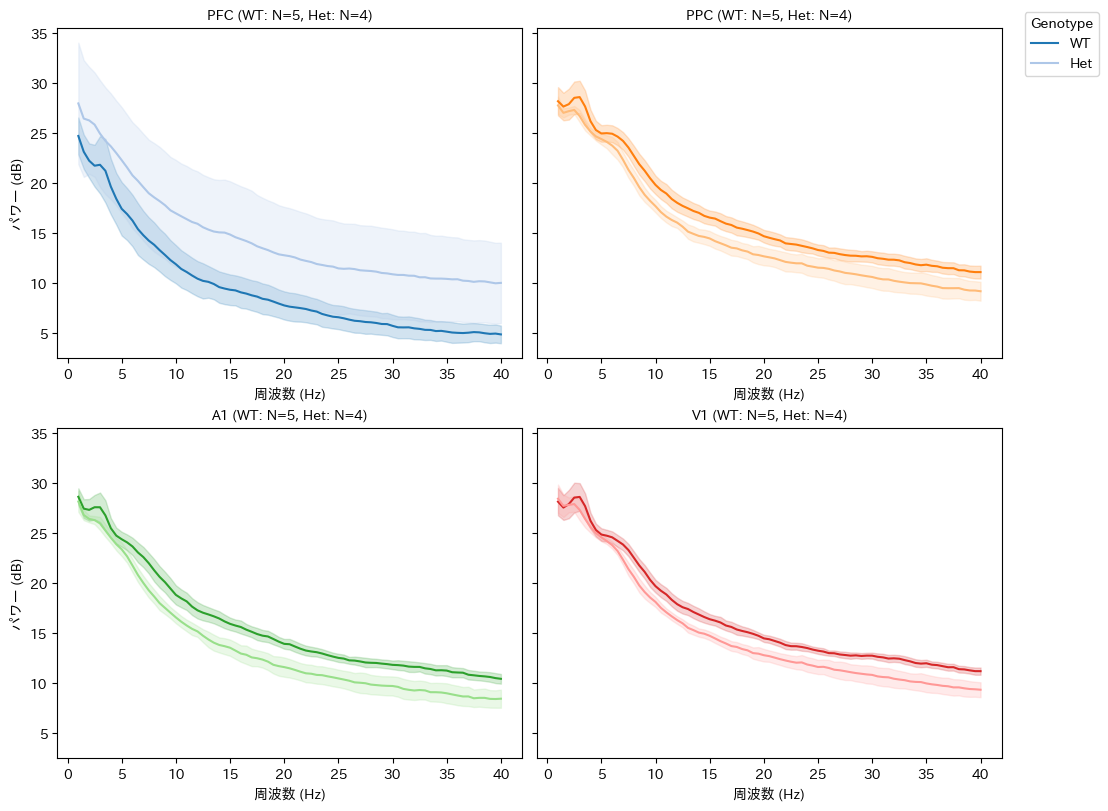

グラフ作成完了。
--- 全てのプロセスが完了しました ---


In [6]:
# %%
# --- セル 7: 実行セル (修正) ---
def main():
    print("--- 安静時PSD解析プロセス開始 ---")
    
    # 1. config 変数のチェック
    if not DATA_DIR.exists():
        print(f"エラー: 指定された DATA_DIR が存在しません: {DATA_DIR}")
        return
    
    # 要件: CH_NAMES_CLEAN は ['PFC', 'PPC', 'A1', 'V1'] の順であること
    expected_channels = ['PFC', 'PPC', 'A1', 'V1']
    if CH_NAMES_CLEAN != expected_channels:
        print(f"警告: config由来のチャネルリスト {CH_NAMES_CLEAN} が期待される順序 {expected_channels} と異なります。")
        # グラフ描画のために順序を強制
        ch_order_for_plot = expected_channels
    else:
        ch_order_for_plot = CH_NAMES_CLEAN

    print(f"入力ディレクトリ: {DATA_DIR}")
    print(f"出力ファイル: {OUTPUT_FILE}")
    print(f"使用チャネル (計算対象): {CH_NAMES_CLEAN}")
    print(f"使用チャネル (プロット順): {ch_order_for_plot}")
    
    # 2. [関数 1] ファイル検索
    files_to_process = find_files_to_process(DATA_DIR)
    
    if not files_to_process:
        print("処理対象ファイルが見つからないため、プロセスを終了します。")
        return

    # 3. [関数 2] PSD計算と集計
    summary_df = aggregate_psd_from_npy(
        files_to_process=files_to_process,
        ch_names=CH_NAMES_CLEAN, # PSD計算時は config の順序を維持
        sfreq=SAMPLING_RATE,
        start_sec=TIME_SLICE_START_SEC,
        end_sec=TIME_SLICE_END_SEC,
        duration=WELCH_DURATION_SEC,
        fmin=PSD_FMIN,
        fmax=PSD_FMAX,
        n_jobs=N_JOBS
    )
    
    if summary_df.empty:
        print("集計データが空のため、プロセスを終了します。")
        return
        
    # 4. 集計データの保存
    try:
        OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
        summary_df.to_parquet(OUTPUT_FILE, index=False)
        print(f"集計データを {OUTPUT_FILE} に保存しました。")
    except Exception as e:
        print(f"エラー: 集計データの保存に失敗しました。 | {e}")

    # 5. [関数 3] 可視化
    # CH_NAMES_CLEAN が ['PFC', 'PPC', 'A1', 'V1'] の順であることを前提とする
    plot_grouped_psd(summary_df, ch_order=ch_order_for_plot)
    
    print("--- 全てのプロセスが完了しました ---")

if __name__ == "__main__":
    # Jupyter/IPython 環境ではセルを直接実行してください。
    # .py ファイルとして実行する場合は 'if __name__ == "__main__":' が機能します。
    main()